In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import requests
import geopandas as gpd
import omnivida_loader as ov
import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
%matplotlib inline

### Let's start by loading the cleansed datasets into pandas DataFrames. 

In [2]:
adherence, adherence_change = ov.get_adherence_dataset()
familiar_records = ov.get_family_records_dataset()

### Familiar records

In [3]:
familiar_records.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
familiar_records.head()

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
0,1998401,EPS/SURA,2012-07-09,"ASMA, NO ESPECIFICADA",J459,MADRE,2012
1,535255,EPS/SURA,2011-07-29,"DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION...",E149,ABUELO,2011
2,1004538,EPS/SURA,2012-01-17,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
3,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,PADRE,2012
4,788432,EPS/SURA,2012-01-06,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,2012


In [4]:
familiar_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_patient       104 non-null    int64         
 1   health_provider  104 non-null    category      
 2   creation_date    104 non-null    datetime64[ns]
 3   diagnosis        104 non-null    category      
 4   diagnosis_code   104 non-null    category      
 5   relationship     104 non-null    category      
 6   record_year      104 non-null    int64         
dtypes: category(4), datetime64[ns](1), int64(2)
memory usage: 6.3 KB


In [5]:
familiar_records.describe(include='all')

,id_patient,health_provider,creation_date,diagnosis,diagnosis_code,relationship,record_year
count,1.040000e+02,104,104,104,104,104,104.000000
unique,NaN,2,50,32,32,6,NaN
top,NaN,EPS/SURA,2011-09-13 00:00:00,HIPERTENSION ESENCIAL (PRIMARIA),I10X,MADRE,NaN
freq,NaN,99,6,30,30,35,NaN
first,NaN,NaN,2010-12-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,2019-06-19 00:00:00,NaN,NaN,NaN,NaN
mean,1.299300e+06,NaN,NaN,NaN,NaN,NaN,2012.721154
std,4.405538e+05,NaN,NaN,NaN,NaN,NaN,2.278889
min,5.294100e+05,NaN,NaN,NaN,NaN,NaN,2010.000000
25%,8.967585e+05,NaN,NaN,NaN,NaN,NaN,2011.000000


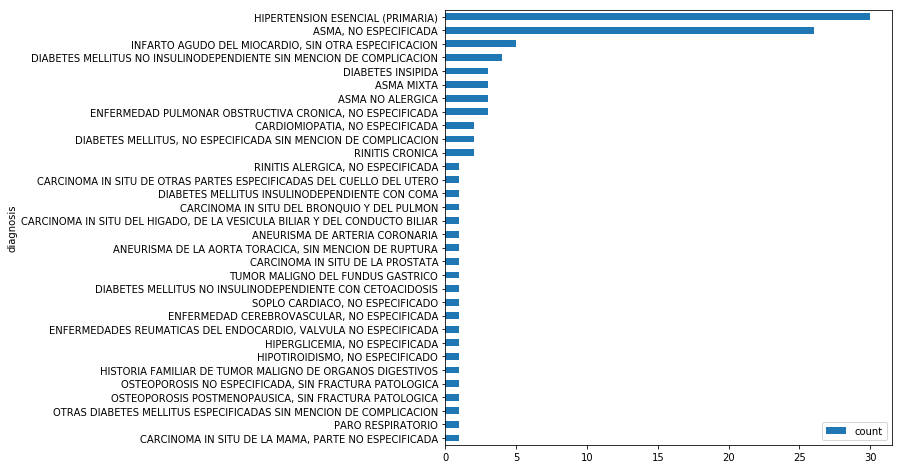

In [6]:
diagnosis = familiar_records[['id_patient', 'diagnosis']].groupby('diagnosis').size().sort_values(ascending=False).reset_index(name='count')
diagnosis.sort_values(by='count', ascending=True).plot(kind='barh', x='diagnosis', figsize=(8,8))

In [7]:
familiar_records.diagnosis.cat.categories

Index(['ANEURISMA DE ARTERIA CORONARIA',
       'ANEURISMA DE LA AORTA TORACICA, SIN MENCION DE RUPTURA', 'ASMA MIXTA',
       'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA',
       'CARCINOMA IN SITU DE LA MAMA, PARTE NO ESPECIFICADA',
       'CARCINOMA IN SITU DE LA PROSTATA',
       'CARCINOMA IN SITU DE OTRAS PARTES ESPECIFICADAS DEL CUELLO DEL UTERO',
       'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON',
       'CARCINOMA IN SITU DEL HIGADO, DE LA VESICULA BILIAR Y DEL CONDUCTO BILIAR',
       'CARDIOMIOPATIA, NO ESPECIFICADA', 'DIABETES INSIPIDA',
       'DIABETES MELLITUS INSULINODEPENDIENTE CON COMA',
       'DIABETES MELLITUS NO INSULINODEPENDIENTE CON CETOACIDOSIS',
       'DIABETES MELLITUS NO INSULINODEPENDIENTE SIN MENCION DE COMPLICACION',
       'DIABETES MELLITUS, NO ESPECIFICADA SIN MENCION DE COMPLICACION',
       'ENFERMEDAD CEREBROVASCULAR, NO ESPECIFICADA',
       'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA',
       'ENFERMEDADES REUMATICAS DEL ENDOCARDI

In [8]:
respiratory_related_diagnosis = ['ASMA MIXTA', 'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA', 
                                 'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON', 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA']

consolidated_family_record = pd.DataFrame()
for paciente, df in familiar_records.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['family_history_reported'] = 1
    row['num_family_records'] = temp_df.shape[0]
    row['family_respiratory_related_diagnosis'] = len(temp_df[temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    row['family_non_respiratory_related_diagnosis'] = len(temp_df[~temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    consolidated_family_record = consolidated_family_record.append(row, ignore_index=True)

# Rearrange columns
consolidated_family_record = consolidated_family_record[
    ['id_patient', 'family_history_reported', 'num_family_records', 
     'family_respiratory_related_diagnosis', 'family_non_respiratory_related_diagnosis']
]

consolidated_family_record

,id_patient,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,529410.0,1.0,1.0,0.0,1.0
1,535255.0,1.0,1.0,0.0,1.0
2,557377.0,1.0,1.0,0.0,1.0
3,664340.0,1.0,2.0,2.0,0.0
4,673765.0,1.0,1.0,1.0,0.0
5,674247.0,1.0,7.0,1.0,6.0
6,679525.0,1.0,1.0,0.0,1.0
7,716377.0,1.0,1.0,1.0,0.0
8,738900.0,1.0,1.0,0.0,1.0
9,788432.0,1.0,4.0,0.0,4.0


In [9]:
adherence.head()

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A


In [10]:
adherence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_patient           4765 non-null   int64         
 1   survey_date          4765 non-null   datetime64[ns]
 2   morisky_green        4765 non-null   float64       
 3   smaq1                4765 non-null   float64       
 4   smaq2                4765 non-null   float64       
 5   espa                 4765 non-null   float64       
 6   nm_espa              4765 non-null   float64       
 7   qualitative_result   4765 non-null   float64       
 8   quantitative_result  4765 non-null   float64       
 9   category             4765 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(7), int64(1)
memory usage: 340.0 KB


In [11]:
adherence.describe(include='all')

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
count,4.765000e+03,4765,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765
unique,NaN,1433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,2019-04-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
freq,NaN,86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2319
first,NaN,2012-04-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.238039e+06,NaN,0.849528,0.836726,3.774816,0.830220,5.603148,0.793494,3.774816,NaN
std,4.295039e+05,NaN,0.357571,0.369654,0.798742,0.375478,0.912014,0.404840,0.798742,NaN
min,5.005470e+05,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,8.716330e+05,NaN,1.000000,1.000000,4.000000,1.000000,5.000000,1.000000,4.000000,NaN


,id_patient,count_records
0,1769865,41
1,979605,30
2,1132214,28
3,1676414,26
4,622031,26
5,1196034,25
6,916510,24
7,1828862,23
8,1536265,23
9,1399081,23


4765


Text(0.5,1,'Number of adherence records per patient')

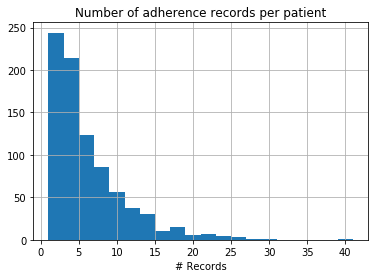

In [12]:
num_records_per_patient = adherence.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_patient.head(10))
print(sum(num_records_per_patient['count_records']))
num_records_per_patient.hist('count_records', bins=20)
plt.xlabel('# Records')
plt.title('Number of adherence records per patient')

,category,count_records
0,A,2319
1,M,1251
2,A-,689
3,N+,496
4,N,10


4765


Text(0.5,1,'Number records per category')

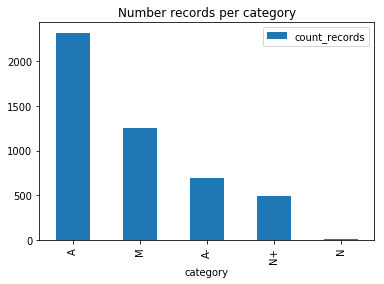

In [13]:
num_records_per_category = adherence.groupby('category').size().sort_values(ascending=False).reset_index(name='count_records')
display(num_records_per_category)
print(sum(num_records_per_category['count_records']))
num_records_per_category.plot(kind='bar', x='category')
# plt.xlabel('# Records')
plt.title('Number records per category')

In [14]:
adherence_change.head(10)

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category,morisky_change,smaq1_change,smaq2_change,espa_change,nm_espa_change,qualitative_result_change,quantitative_result_change,days_since_last_control,num_reports,ongoing_adherence_percentage
0,500547,2016-07-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
1,500547,2019-03-14,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,976.0,2,100.0
2,500547,2019-10-11,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.0,3,100.0
3,500547,2019-12-09,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,4,100.0
4,500547,2020-01-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,5,100.0
5,500547,2020-03-25,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,6,100.0
6,500547,2020-05-08,1.0,1.0,4.0,1.0,5.0,1.0,4.0,A,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,44.0,7,100.0
7,500588,2019-04-26,1.0,1.0,4.0,1.0,6.0,1.0,4.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,100.0
8,502989,2014-08-22,0.0,0.0,2.0,1.0,5.0,0.0,2.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
9,502989,2014-10-28,0.0,0.0,2.0,0.0,5.0,0.0,2.0,M,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,67.0,2,0.0


In [15]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'quantitative_result', 'qualitative_result_change', 'quantitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.000000
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.000000
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.000000
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.000000
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.000000
5,500547,2020-03-25,A,1.0,4.0,0.0,0.0,69.0,100.000000
6,500547,2020-05-08,A,1.0,4.0,0.0,0.0,44.0,100.000000
7,500588,2019-04-26,A,1.0,4.0,NaN,NaN,NaN,100.000000
8,502989,2014-08-22,M,0.0,2.0,NaN,NaN,NaN,0.000000
9,502989,2014-10-28,M,0.0,2.0,0.0,0.0,67.0,0.000000


In [16]:
adherence_change_analysis_pivot = adherence_change_analysis.copy()
adherence_change_analysis_pivot['survey_month'] = adherence_change_analysis_pivot['survey_date'].dt.month
adherence_change_analysis_pivot['survey_year'] = adherence_change_analysis_pivot['survey_date'].dt.year
adherence_pivot_dias_control = pd.pivot_table(adherence_change_analysis_pivot, values='days_since_last_control', index='survey_month', columns='survey_year', aggfunc='mean')
adherence_pivot_adher_percentage = pd.pivot_table(adherence_change_analysis_pivot, values='ongoing_adherence_percentage', index='survey_month', columns='survey_year', aggfunc='mean')

Text(0.5,1,'Dias desde el ultimo control')

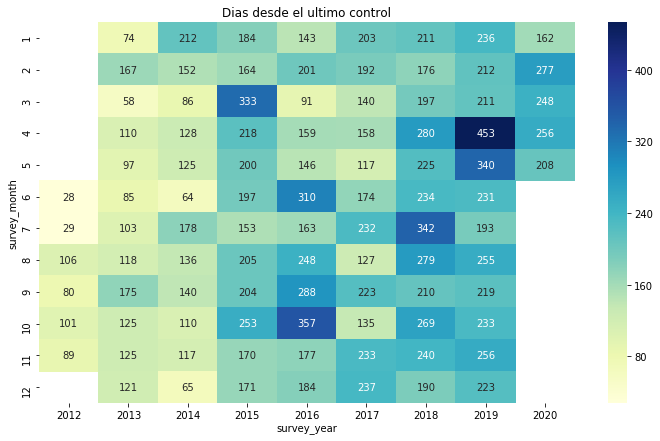

In [17]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_dias_control, ax=ax, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title('Dias desde el ultimo control')

Text(0.5,1,'Porcentage de adherencia historico promedio por mes')

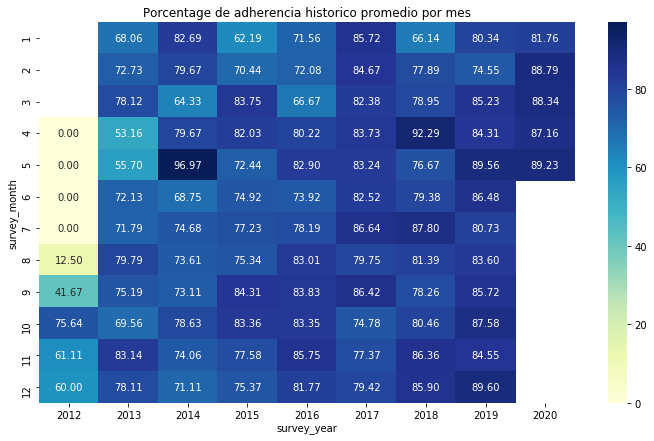

In [18]:
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(adherence_pivot_adher_percentage, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Porcentage de adherencia historico promedio por mes')

#### Let's have a look at those patients that went from `adherent` (i.e. 1 in the `cualitativo_ponderado` field) to `non-adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [19]:
neg_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==-1]
neg_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
14,502989,2016-01-12,M,0.0,3.0,-1.0,-1.0,201.0,14.285714
16,502989,2017-01-03,M,0.0,3.0,-1.0,-1.0,354.0,22.222222
20,502989,2018-10-03,M,0.0,4.0,-1.0,0.0,421.0,38.461538
35,506808,2018-10-08,M,0.0,4.0,-1.0,0.0,131.0,85.714286
44,512938,2018-05-04,M,0.0,4.0,-1.0,0.0,216.0,85.714286
48,512938,2019-09-30,M,0.0,1.0,-1.0,-3.0,293.0,72.727273
51,514102,2018-01-30,A,0.0,4.0,-1.0,0.0,74.0,66.666667
55,524006,2015-10-13,A-,0.0,4.0,-1.0,0.0,33.0,66.666667
62,524006,2017-05-10,A-,0.0,3.0,-1.0,-1.0,28.0,70.000000
93,529410,2018-01-30,A-,0.0,4.0,-1.0,0.0,122.0,66.666667


In [20]:
neg_transition_count = neg_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_neg_transitions')
neg_transition_count.head(10)

,id_patient,count_neg_transitions
0,1769865,7
1,832593,7
2,622031,6
3,739693,6
4,673765,6
5,916510,6
6,1828862,5
7,1132214,5
8,747471,5
9,801004,5


Text(0.5,1,'Number of negative transitions per month')

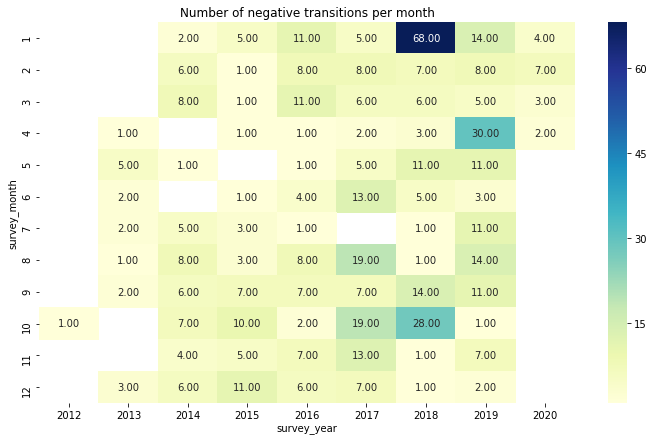

In [21]:
neg_transition_pivot = neg_transition.copy()
neg_transition_pivot['survey_month'] = neg_transition_pivot['survey_date'].dt.month
neg_transition_pivot['survey_year'] = neg_transition_pivot['survey_date'].dt.year
neg_transition_pivot = pd.pivot_table(neg_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(neg_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of negative transitions per month')

#### Let's have a look at those patients that went from `non-adherent` (i.e. 0 in the `cualitativo_ponderado` field) to `adherent` (i.e. 1 in the `cualitativo_ponderado` field) 

In [22]:
pos_transition = adherence_change_analysis[adherence_change_analysis['qualitative_result_change']==1]
pos_transition.head(10)

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage
13,502989,2015-06-25,M,1.0,4.0,1.0,1.0,162.0,16.666667
15,502989,2016-01-15,M,1.0,4.0,1.0,1.0,3.0,25.000000
17,502989,2017-03-21,M,1.0,4.0,1.0,1.0,77.0,30.000000
21,502989,2019-02-08,M,1.0,4.0,1.0,0.0,128.0,42.857143
23,506808,2013-05-24,M,1.0,4.0,1.0,0.0,16.0,50.000000
37,506808,2019-06-14,M,1.0,4.0,1.0,4.0,113.0,81.250000
46,512938,2018-11-14,M,1.0,4.0,1.0,0.0,42.0,77.777778
52,514102,2018-09-25,A,1.0,4.0,1.0,0.0,238.0,75.000000
57,524006,2016-06-02,A-,1.0,4.0,1.0,0.0,206.0,60.000000
63,524006,2017-07-28,A-,1.0,4.0,1.0,1.0,79.0,72.727273


In [23]:
pos_transition_count = pos_transition.groupby('id_patient').size().sort_values(ascending=False).reset_index(name='count_pos_transitions')
pos_transition_count.head(10)

,id_patient,count_pos_transitions
0,1769865,8
1,622031,7
2,832593,7
3,1132214,6
4,673765,6
5,739693,6
6,1399081,5
7,801004,5
8,747471,5
9,916510,5


Text(0.5,1,'Number of positive transitions per month')

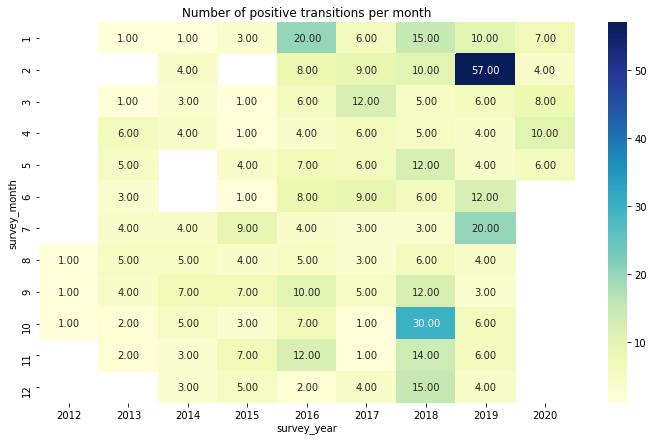

In [24]:
pos_transition_pivot = pos_transition.copy()
pos_transition_pivot['survey_month'] = pos_transition_pivot['survey_date'].dt.month
pos_transition_pivot['survey_year'] = pos_transition_pivot['survey_date'].dt.year
pos_transition_pivot = pd.pivot_table(pos_transition_pivot, values='id_patient', index='survey_month', columns='survey_year', aggfunc='count')

fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(pos_transition_pivot, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title('Number of positive transitions per month')

#### Let's get the last reported adherence status for each of the users in the available dataset

In [25]:
last_reported_adherence = pd.DataFrame()
for paciente, df in adherence_change.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['num_reports'] = temp_df.shape[0]
    row['qualitative_result'] = temp_df.iloc[-1]['qualitative_result']
    row['quantitative_result'] = temp_df.iloc[-1]['quantitative_result']
    row['category'] = temp_df.iloc[0]['category']
    row['avg_days_since_last_control'] = temp_df['days_since_last_control'].mean()
    row['ongoing_adherence_percentage'] = temp_df.iloc[-1]['ongoing_adherence_percentage']
    last_reported_adherence = last_reported_adherence.append(row, ignore_index=True)

# Rearrange columns
last_reported_adherence = last_reported_adherence[
    ['id_patient', 'num_reports', 'qualitative_result', 
     'quantitative_result', 'avg_days_since_last_control', 'ongoing_adherence_percentage', 'category']
]

display(last_reported_adherence.head(10))
last_reported_adherence.shape

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category
0,500547.0,7.0,1.0,4.0,232.833333,100.000000,A
1,500588.0,1.0,1.0,4.0,NaN,100.000000,A
2,502989.0,14.0,1.0,4.0,125.461538,42.857143,M
3,506808.0,16.0,1.0,4.0,148.533333,81.250000,M
4,512938.0,11.0,0.0,1.0,167.900000,72.727273,M
5,514102.0,4.0,1.0,4.0,625.333333,75.000000,A
6,524006.0,14.0,1.0,4.0,123.384615,78.571429,A-
7,524902.0,1.0,1.0,4.0,NaN,100.000000,A
8,525295.0,2.0,1.0,4.0,173.000000,100.000000,A
9,525540.0,1.0,1.0,4.0,NaN,100.000000,A


(840, 7)

#### Let's study the influence of familiar health background on patients adherence

In [26]:
familiar_record_adherence = last_reported_adherence.merge(consolidated_family_record, how='left', on='id_patient')
familiar_record_adherence['category'] = familiar_record_adherence['category'].astype('category')
familiar_record_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
familiar_record_adherence['family_history_reported'] = familiar_record_adherence['family_history_reported'].fillna(0)

In [27]:
familiar_record_adherence.head(20)

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,500547.0,7.0,1.0,4.0,232.833333,100.000000,A,0.0,NaN,NaN,NaN
1,500588.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN
2,502989.0,14.0,1.0,4.0,125.461538,42.857143,M,0.0,NaN,NaN,NaN
3,506808.0,16.0,1.0,4.0,148.533333,81.250000,M,0.0,NaN,NaN,NaN
4,512938.0,11.0,0.0,1.0,167.900000,72.727273,M,0.0,NaN,NaN,NaN
5,514102.0,4.0,1.0,4.0,625.333333,75.000000,A,0.0,NaN,NaN,NaN
6,524006.0,14.0,1.0,4.0,123.384615,78.571429,A-,0.0,NaN,NaN,NaN
7,524902.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN
8,525295.0,2.0,1.0,4.0,173.000000,100.000000,A,0.0,NaN,NaN,NaN
9,525540.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN


In [28]:
familiar_record_adherence.shape

(840, 11)

In [29]:
adherence_with_reported_familiar_history = familiar_record_adherence[familiar_record_adherence['family_history_reported']==1]
adherence_no_reported_familiar_history = familiar_record_adherence[familiar_record_adherence['family_history_reported']==0]

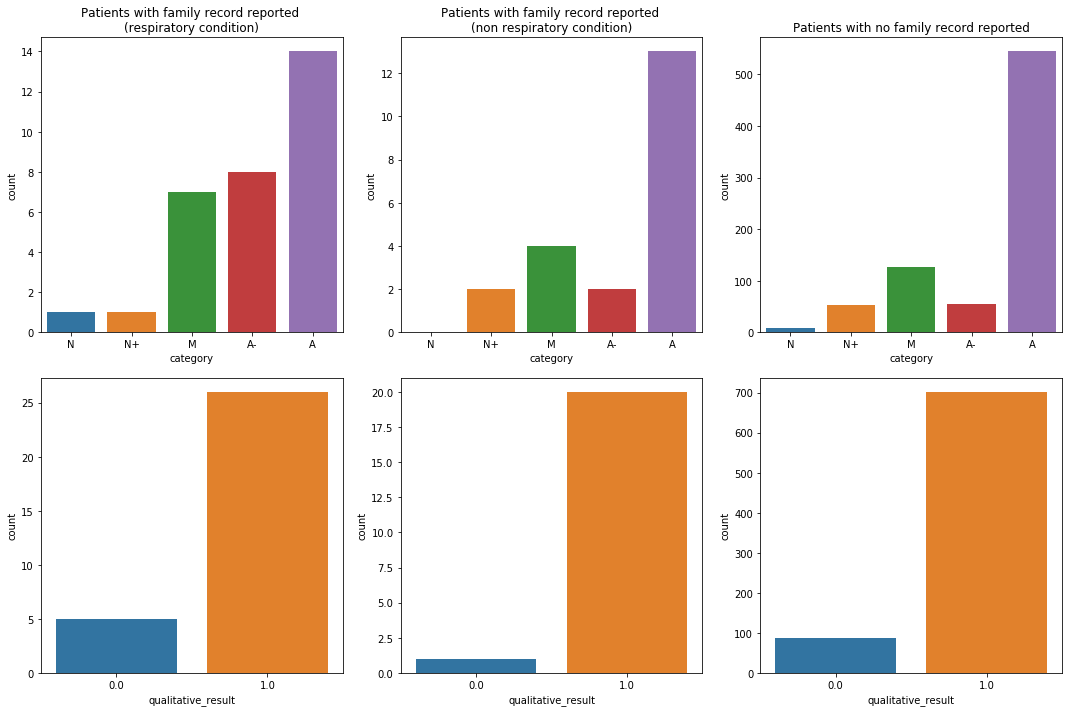

In [30]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0].groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with family record reported \n(respiratory condition)')
plt.subplot(2,3,2)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0].groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with family record reported \n(non respiratory condition)')
plt.subplot(2,3,3)
sns.barplot(data=adherence_no_reported_familiar_history.groupby('category').size().reset_index(name='count'), x='category', y='count')
plt.title('Patients with no family record reported')
plt.subplot(2,3,4)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0].groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.subplot(2,3,5)
sns.barplot(data=adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0].groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.subplot(2,3,6)
sns.barplot(data=adherence_no_reported_familiar_history.groupby('qualitative_result').size().reset_index(name='count'), x='qualitative_result', y='count')
plt.tight_layout()

In [31]:
adherence_with_reported_familiar_history_resp = adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0]
adherence_with_reported_familiar_history_no_resp = adherence_with_reported_familiar_history[adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0]

In [32]:
avg_adherence_familiar_history_resp = adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage.mean() 
avg_adherence_familiar_history_no_resp = adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage.mean()
avg_adherence_no_familiar_reports = adherence_no_reported_familiar_history.ongoing_adherence_percentage.mean()

In [33]:
print(f"Average ongoing adherence for patients with relatives with respiratory conditions: {round(avg_adherence_familiar_history_resp, 2)}")
print(f"Average ongoing adherence for patients with relatives with conditions other than respiratory: {round(avg_adherence_familiar_history_no_resp, 2)}")
print(f"Average ongoing adherence for patients which haven't report any familiar history: {round(avg_adherence_no_familiar_reports, 2)}")

Average ongoing adherence for patients with relatives with respiratory conditions: 73.82
Average ongoing adherence for patients with relatives with conditions other than respiratory: 86.93
Average ongoing adherence for patients which haven't report any familiar history: 84.8


In [34]:
adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage.describe()

count     31.000000
mean      73.821767
std       22.091677
min        0.000000
25%       60.000000
50%       77.272727
75%       90.598291
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

In [35]:
adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage.describe()

count     21.000000
mean      86.928570
std       16.766308
min       50.000000
25%       76.923077
50%      100.000000
75%      100.000000
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

In [36]:
adherence_no_reported_familiar_history.ongoing_adherence_percentage.describe()

count    788.000000
mean      84.802022
std       20.507896
min        0.000000
25%       75.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: ongoing_adherence_percentage, dtype: float64

Text(0.5,1,'Patients with no family record reported')

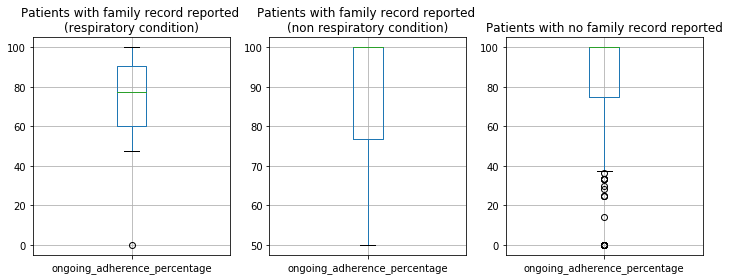

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
adherence_with_reported_familiar_history_resp.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with family record reported \n(respiratory condition)')
plt.subplot(1,3,2)
adherence_with_reported_familiar_history_no_resp.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with family record reported \n(non respiratory condition)')
plt.subplot(1,3,3)
adherence_no_reported_familiar_history.boxplot(column=['ongoing_adherence_percentage'])
plt.title('Patients with no family record reported')

In [38]:
from scipy import stats

statistic, pvalue = stats.ttest_ind(adherence_with_reported_familiar_history_resp.ongoing_adherence_percentage, adherence_with_reported_familiar_history_no_resp.ongoing_adherence_percentage, equal_var=False, nan_policy='omit')
statistic, pvalue

(-2.4284584980606017, 0.018858076741265956)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


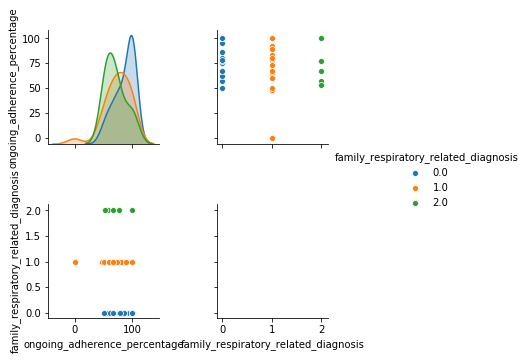

In [39]:
sns.pairplot(familiar_record_adherence[['ongoing_adherence_percentage', 'family_respiratory_related_diagnosis']], hue='family_respiratory_related_diagnosis')

In [40]:
familiar_record_non_adherent_patients = familiar_record_adherence[(familiar_record_adherence['quantitative_result'] < 4) & (familiar_record_adherence['qualitative_result']==0)]
familiar_record_non_adherent_patients

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
4,512938.0,11.0,0.0,1.0,167.900000,72.727273,M,0.0,NaN,NaN,NaN
13,529410.0,7.0,0.0,3.0,415.333333,57.142857,A-,1.0,1.0,0.0,1.0
15,530244.0,2.0,0.0,3.0,128.000000,50.000000,M,0.0,NaN,NaN,NaN
18,537607.0,5.0,0.0,3.0,32.000000,80.000000,A-,0.0,NaN,NaN,NaN
36,566408.0,2.0,0.0,3.0,513.000000,50.000000,M,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
786,1919132.0,4.0,0.0,0.0,242.666667,75.000000,N+,0.0,NaN,NaN,NaN
787,1919531.0,1.0,0.0,2.0,NaN,0.000000,N,0.0,NaN,NaN,NaN
803,1952172.0,10.0,0.0,3.0,138.777778,30.000000,A-,0.0,NaN,NaN,NaN
829,1988890.0,2.0,0.0,2.0,50.000000,0.000000,N,0.0,NaN,NaN,NaN


In [41]:
familiar_record_adherent_patients = familiar_record_adherence[(familiar_record_adherence['quantitative_result'] == 4) & (familiar_record_adherence['qualitative_result']==1)]
familiar_record_adherent_patients

,id_patient,num_reports,qualitative_result,quantitative_result,avg_days_since_last_control,ongoing_adherence_percentage,category,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,500547.0,7.0,1.0,4.0,232.833333,100.000000,A,0.0,NaN,NaN,NaN
1,500588.0,1.0,1.0,4.0,NaN,100.000000,A,0.0,NaN,NaN,NaN
2,502989.0,14.0,1.0,4.0,125.461538,42.857143,M,0.0,NaN,NaN,NaN
3,506808.0,16.0,1.0,4.0,148.533333,81.250000,M,0.0,NaN,NaN,NaN
5,514102.0,4.0,1.0,4.0,625.333333,75.000000,A,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
835,1997065.0,14.0,1.0,4.0,153.307692,85.714286,M,0.0,NaN,NaN,NaN
836,1997825.0,3.0,1.0,4.0,280.500000,66.666667,M,0.0,NaN,NaN,NaN
837,1998401.0,12.0,1.0,4.0,167.090909,66.666667,A-,1.0,1.0,1.0,0.0
838,1999536.0,2.0,1.0,4.0,563.000000,100.000000,A,0.0,NaN,NaN,NaN


In [42]:
adherence[adherence['id_patient']==1012279]

,id_patient,survey_date,morisky_green,smaq1,smaq2,espa,nm_espa,qualitative_result,quantitative_result,category
1663,1012279,2018-07-27,1.0,1.0,4.0,1.0,6.0,1.0,4.0,M
1664,1012279,2019-06-11,0.0,0.0,3.0,1.0,5.0,0.0,3.0,M
1665,1012279,2019-07-16,1.0,1.0,4.0,1.0,6.0,1.0,4.0,M
1666,1012279,2020-02-22,1.0,1.0,4.0,0.0,5.0,0.0,4.0,M


In [43]:
print(familiar_record_adherent_patients.shape)
print(familiar_record_non_adherent_patients.shape)

(748, 11)
(70, 11)


# Frequency analysis

In [44]:
full_familiar_record_adherence = adherence_change_analysis.merge(consolidated_family_record, how='left', on='id_patient')
full_familiar_record_adherence['category'] = full_familiar_record_adherence['category'].astype('category')
full_familiar_record_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
full_familiar_record_adherence['family_history_reported'] = full_familiar_record_adherence['family_history_reported'].fillna(0)
full_familiar_record_adherence

,id_patient,survey_date,category,qualitative_result,quantitative_result,qualitative_result_change,quantitative_result_change,days_since_last_control,ongoing_adherence_percentage,family_history_reported,num_family_records,family_respiratory_related_diagnosis,family_non_respiratory_related_diagnosis
0,500547,2016-07-11,A,1.0,4.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN,NaN
1,500547,2019-03-14,A,1.0,4.0,0.0,0.0,976.0,100.0,0.0,NaN,NaN,NaN
2,500547,2019-10-11,A,1.0,4.0,0.0,0.0,211.0,100.0,0.0,NaN,NaN,NaN
3,500547,2019-12-09,A,1.0,4.0,0.0,0.0,59.0,100.0,0.0,NaN,NaN,NaN
4,500547,2020-01-16,A,1.0,4.0,0.0,0.0,38.0,100.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4760,1999536,2018-08-08,A,1.0,4.0,NaN,NaN,NaN,100.0,0.0,NaN,NaN,NaN
4761,1999536,2020-02-22,A,1.0,4.0,0.0,0.0,563.0,100.0,0.0,NaN,NaN,NaN
4762,1999629,2018-04-06,A,1.0,4.0,NaN,NaN,NaN,100.0,1.0,2.0,1.0,1.0
4763,1999629,2018-05-04,A,1.0,4.0,0.0,0.0,28.0,100.0,1.0,2.0,1.0,1.0


In [45]:
full_adherence_with_reported_familiar_history = full_familiar_record_adherence[full_familiar_record_adherence['family_history_reported']==1]
full_adherence_no_reported_familiar_history = full_familiar_record_adherence[full_familiar_record_adherence['family_history_reported']==0]

full_adherence_with_reported_familiar_history_resp = full_adherence_with_reported_familiar_history[full_adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] > 0]
full_adherence_with_reported_familiar_history_no_resp = full_adherence_with_reported_familiar_history[full_adherence_with_reported_familiar_history['family_respiratory_related_diagnosis'] == 0]

prob_df_data = []

pat, pnt, pt = ovu.compute_transition_probabilities(full_adherence_with_reported_familiar_history_resp)
print(f'Patients with relatives with respiratory conditions: ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

pat, pnt, pt = ovu.compute_transition_probabilities(full_adherence_with_reported_familiar_history_no_resp)
print(f'Patients with relatives with conditions other than respiratory: ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

pat, pnt, pt = ovu.compute_transition_probabilities(full_adherence_no_reported_familiar_history)
print(f'Patients which haven\'t report any familiar history: ')
print(f'\nProbability of a patient going from Non-adherent to Adherent: {round(pat, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt, 2)}')

prob_df_data.append([round(pat, 2), round(pnt, 2), round(pt, 2)])

pat_full_data, pnt_full_data, pt_full_data = ovu.compute_transition_probabilities(adherence_change_analysis)

print(f'Probability of a patient going from Non-adherent to Adherent: {round(pat_full_data, 2)}')
print(f'Probability of a patient staying non-adherent: {round(1-pat_full_data, 2)}')
print(f'\nProbability of a patient going from Adherent to Non-adherent: {round(pnt_full_data, 2)}')
print(f'Probability of a patient staying Adherent: {round(1-pnt_full_data, 2)}')
print(f'\nProbability of a patient transitioning (NA -> A or A -> NA): {round(pt_full_data, 2)}')
print(f'Probability of a patient remaining unchaged: {round(1-pt_full_data, 2)}')

prob_df_data.append([round(pat_full_data, 2), round(pnt_full_data, 2), round(pt_full_data, 2)])

prob_df = pd.DataFrame(index=['Relatives resp. hist.', 'Relatives NO resp. hist', 'NO family history', 'Full dataset'], columns=['P(N-A)', 'P(A-N)', 'P(Transition)'], data=prob_df_data)
prob_df

Patients with relatives with respiratory conditions: 

Probability of a patient going from Non-adherent to Adherent: 0.71
Probability of a patient staying non-adherent: 0.29

Probability of a patient going from Adherent to Non-adherent: 0.29
Probability of a patient staying Adherent: 0.71

Probability of a patient transitioning (NA -> A or A -> NA): 0.42
Probability of a patient remaining unchaged: 0.58
Patients with relatives with conditions other than respiratory: 

Probability of a patient going from Non-adherent to Adherent: 0.74
Probability of a patient staying non-adherent: 0.26

Probability of a patient going from Adherent to Non-adherent: 0.13
Probability of a patient staying Adherent: 0.87

Probability of a patient transitioning (NA -> A or A -> NA): 0.25
Probability of a patient remaining unchaged: 0.75
Patients which haven't report any familiar history: 

Probability of a patient going from Non-adherent to Adherent: 0.64
Probability of a patient staying non-adherent: 0.36

P

,P(N-A),P(A-N),P(Transition)
Relatives resp. hist.,0.71,0.29,0.42
Relatives NO resp. hist,0.74,0.13,0.25
NO family history,0.64,0.18,0.28
Full dataset,0.65,0.19,0.29
